### Import Packages

In [ ]:
import flappy_bird_gym
import numpy as np
from collections import deque
import random

import matplotlib.pyplot as plt
import skimage as skimage
from skimage import transform

import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Activation

import json
import time

### Step 1: Developing Convolutional Neural Network (CNN)

In [ ]:
class Model:
    def __init__(self):
        self.input_shape = (80,80,4)
        self.activation = 'relu'
        self.learning_rate = 0.005
        self.kernel_init = tf.keras.initializers.HeUniform()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.loss = tf.keras.losses.CategoricalCrossentropy()

    def convolution_model(self):
        model = Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=self.input_shape))
        model.add(tf.keras.layers.Conv2D(32, kernel_size=(8,8), strides=(4,4), padding='same', 
                                      activation = self.activation))
        model.add(tf.keras.layers.Conv2D(64, kernel_size=(4,4), strides=(2,2), padding='same', 
                                      activation = self.activation))
        model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', 
                                      activation =self.activation))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(512,kernel_initializer=self.kernel_init))
        model.add(tf.keras.layers.Dense(2,activation='sigmoid')) 
        model.compile(loss=self.loss, optimizer= self.optimizer, 
                                  metrics=[tf.keras.metrics.CategoricalAccuracy()])
        return model

### Step 2: Programming a function for Deep Q-Learning

In [ ]:
def DQN(env, model, observation, epsilon, final_epsilon, batch, gamma, games, amount_frame):
    global step_action
    global Q_state
    global step_reward
    global step_state
    global mini_batch
    global image_reshape_keras_next
    global image_reshape_keras
    global nextstep_state
    global max_Q
    
    dict_agent = {}
    
    replay_memory = deque()
    actions = env.action_space.n
    game = 0
    
    action = [1,0]
    env.reset()
    obs, reward, done, info = env.step(action)
    
    image = skimage.color.rgb2gray(obs)
    image = skimage.transform.resize(image,(80,80))
    image = skimage.exposure.rescale_intensity(image,out_range=(0,255))
    image = image / 255.0
    un, cts = np.unique(image.reshape(6400),return_counts=True)
    dict(zip(un,cts))

    image = image.reshape(6400)
    image = np.where((image >= 0.8),1,image)
    image = image.reshape(80,80)
    image = np.stack((image, image, image,image), axis=2)
    image_reshape_keras = image.reshape(1, image.shape[0], image.shape[1], image.shape[2]) 
    
    step = 0
    while game < games:
        done = False
        
        while not done:
            loss = 0
            Q_state = 0
            next_reward = 0
            action_step = 1
            if random.random() <= epsilon:
                if np.random.choice(actions):
                    action_step = 1
                else:
                    action_step = 0
            else:
                Q = model.predict(image_reshape_keras)
                max_Q = np.argmax(Q)
                if max_Q:
                    action_step = 1
                else:
                    action_step = 0
    

            if epsilon > final_epsilon and step > observation:
                epsilon -=(epsilon - final_epsilon) / amount_frame
                print('Decrease with:',(epsilon - final_epsilon) / amount_frame)

            next_obs, next_reward, done, info = env.step(action_step)

            image_next = skimage.color.rgb2gray(next_obs)
            image_next = skimage.transform.resize(image_next,(80,80))
            image_next = skimage.exposure.rescale_intensity(image_next,out_range=(0,255))
            image_next = image_next / 255.0
            image_next = image_next.reshape(6400)
            image_next = np.where((image_next >= 0.8),1,image_next)
            image_next = image_next.reshape(80,80)
            image_next = image_next.reshape(1, image_next.shape[0], image_next.shape[1], 1) 
            image_reshape_keras_next = np.append(image_next, image_reshape_keras[:, :, :, :3], axis=3)
            
            replay_memory.append((image_reshape_keras, action_step, next_reward, image_reshape_keras_next, done))
            if len(replay_memory) > 10000:
                replay_memory.popleft()

            if step > observation:
                mini_batch = random.sample(replay_memory, batch)
                step_state, step_action, step_reward, nextstep_state, done = zip(*mini_batch)
                step_state = np.concatenate(step_state)
                nextstep_state = np.concatenate(nextstep_state)
                target = model.predict(step_state)
                Q_state = model.predict(nextstep_state)
                target[range(batch), step_action] = step_reward + gamma*np.max(Q_state, axis=1)*np.invert(done) 
                loss += model.train_on_batch(step_state, target)
            
            env.render()
            step = step + 1
            dict_agent[step] = {'Epsilon': epsilon, 'Action': action_step, 'Reward': next_reward, 'Score': info, 'Q_max': np.max(Q_state), 'Loss': loss}
            image_reshape_keras = image_reshape_keras_next
            

            if step % 1000 == 0:
                model.save_weights('convolutional_model.h5', overwrite=True)
                with open('convolutional_model.json', 'w') as output_model:
                    json.dump(model.to_json(), output_model)  
                
        
        print(dict_agent[step], game, step)
        game = game + 1
        env.reset()

### Step 3: Playing the game Flappy Bird with the function 

In [2]:
env = flappy_bird_gym.make("FlappyBird-rgb-v0")
model = Model()
model = model.convolution_model()
observation = 2000
epsilon = 0.99
final_epsilon = 0.1
batch = 32
gamma = 0.99
games = 500000
amount_frame = 30000

DQN(env, model, observation, epsilon, final_epsilon, batch, gamma, games, amount_frame)

C:\Users\20184233\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\viewer\utils\__init__.py:1: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  from .core import *


Now we build the model
We finish building the model
chosen action 1
TIMESTEP 1 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 1 / Q_MAX  0 / Loss  0 / Score {'score': 0}
chosen action 1
TIMESTEP 2 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 1 / Q_MAX  0 / Loss  0 / Score {'score': 0}
chosen action 1
TIMESTEP 3 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 1 / Q_MAX  0 / Loss  0 / Score {'score': 0}
chosen action 1
TIMESTEP 4 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 1 / Q_MAX  0 / Loss  0 / Score {'score': 0}
chosen action 1
TIMESTEP 5 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 1 / Q_MAX  0 / Loss  0 / Score {'score': 0}
chosen action 1
TIMESTEP 6 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 1 / Q_MAX  0 / Loss  0 / Score {'score': 0}
chosen action 1
TIMESTEP 7 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 1 / Q_MAX  0 / Loss  0 / Score {'score': 0}
chosen action 1
TIMESTEP 8 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 1 / Q_MAX  0 / Loss  0 /

KeyboardInterrupt: 

### Step 4: Evaluating the model used for the game Flappy Bird

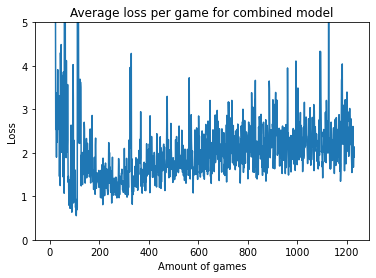

In [39]:
plt.plot(range(0,len(totaaaaal)-1),[a for a in totaaaaal if a < 1000])
plt.ylim(0,5)
plt.title('Average loss per game for combined model')
plt.xlabel('Amount of games')
plt.ylabel('Loss');

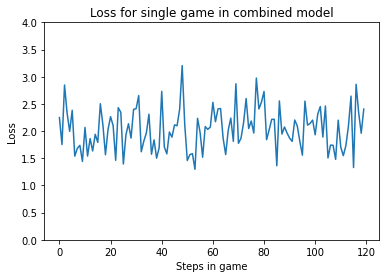

In [40]:
plt.plot(range(0,len(totaaaaal[600:720])),totaaaaal[600:720])
plt.ylim(0,4)
plt.title('Loss for single game in combined model')
plt.xlabel('Steps in game')
plt.ylabel('Loss');